# PPO for Active Suspension System (4-Dim Numerical System)
## Define the dynamic equation

In [1]:
%reset -f

import numpy as np
import gym
from gym import spaces
import numpy as np
from scipy.linalg import expm
from scipy.integrate import quad_vec

class DynamicSystemEnv(gym.Env):
    def __init__(self):
        # parameters
        self.T = 0.05
        self.kus = 232.5e3
        self.mus = 65
        self.ms = 325
        self.ks = 27692.0
        self.cs = 1906.5
        self.ct = 0
        self.ks_max = 40000
        self.ks_min = 10000
        self.cs_max = 3000
        self.cs_min = 500

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # System dynamics parameters
        self.Q = np.array([[10,0,0,0], [0,1,0,0], [0,0,50,0], [0,0,0,5]])     # State cost matrix
        self.R = 0.000001                                 # Action cost
        
        # State and action spaces
        self.observation_space = spaces.Box(low=-2.5, high=2.5, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1000, high=1000, shape=(1,), dtype=np.float32)
        
        # Initial state
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        
        # Maximum episode steps
        self.max_steps = 100
        self.current_step = 0
    
    def sys_matrices(self):
        Ac = np.array([[0,1,0,0], [-self.kus/self.mus,-self.cs/self.mus,self.ks/self.mus,self.cs/self.mus],[0,-1,0,1],[0,self.cs/self.ms,-self.ks/self.ms,-self.cs/self.ms]])
        Bc = np.array([[0],[-1/self.mus],[0],[1/self.ms]])
        Gc = np.array([[-1],[self.ct/self.mus],[0],[0]])
        def funB(t):
            return expm(Ac * t) @ Bc

        def funG(t):
            return expm(Ac * t) @ Gc

        A = expm(Ac * self.T)
        B = quad_vec(funB, 0, self.T)
        B = B[0]
        Gd = quad_vec(funG, 0, self.T)
        Gd = Gd[0]
        return A, B, Gd

    def step(self, action, ks_normalized, cs_normalized):
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        # x_next = np.dot(self.A, x) + np.dot(self.B, action) is the deterministic part
        x_next = np.dot(self.A, x) + np.dot(self.B, action) + np.dot(self.Gd, np.random.normal(loc=0, scale=0.3, size=(1, )))
        
        
        # Calculate reward      
        reward = -x_next@self.Q@x_next.T - self.R * action**2
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps) or (self.state[0]**2+self.state[1]**2+self.state[2]**2+self.state[3]**2<=0.01)
        self.current_step += 1
        
        return self.state, reward[0], done, {}
    
    def step_real(self, action, dzdt, ks_normalized, cs_normalized):
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        knl = 0.01*ks # nonlinear term of spring coefficient
        cnl = 0.01*cs # nonlinear term of damping coefficient

        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd

        # Clip action to stay within action bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        # Update state based on system dynamics
        x = self.state
        x_next = np.dot(self.A, x) + np.dot(self.B, action) + np.dot(self.Gd, dzdt) \
            + np.array([0,-1/self.mus*(knl*x[2]**3+cnl*abs(x[3]-x[1])*(x[3]-x[1])),0,-1/self.ms*(knl*x[2]**3+cnl*abs(x[3]-x[1])*(x[3]-x[1]))])

        # Calculate reward
        reward = -x_next@self.Q@x_next.T - self.R * action**2
                
        # Update state
        self.state = x_next
        
        # Check if done
        done = (self.current_step >= self.max_steps) or (self.state[0]**2+self.state[1]**2+self.state[2]**2+self.state[3]**2<=0.01)
        self.current_step += 1
        
        return self.state, reward[0], done, {}
    
    def reset(self,ks_normalized,cs_normalized):
        # Reset state to initial value
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd
        self.state = np.array([-0.1,-1,-0.1,-0.5])
        self.current_step = 0
        return self.state
    
    def reset_origin(self,ks_normalized,cs_normalized):
        # Reset state to the origin
        ks = ks_normalized*(self.ks_max-self.ks_min)+self.ks_min
        cs = cs_normalized*(self.cs_max-self.cs_min)+self.cs_min
        self.ks = ks
        self.cs = cs
        A, B, Gd = self.sys_matrices()
        self.A = A
        self.B = B
        self.Gd = Gd
        self.state = np.array([0.0, 0.0, 0.0, 0.0])
        self.current_step = 0
        return self.state
    
    def render(self, mode='human'):
        pass

    def close(self):
        pass

## Test the system

In [2]:
import matplotlib.pyplot as plt

env = DynamicSystemEnv()
ks = 27692.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 1906.5
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
s = env.reset(ks_normalized,cs_normalized)

K = np.array([[7.092740795835493e+03,-12.619893117381602,1.327338611165778e+03,-9.462992790543780e+02]])
x_sys = np.zeros((4,101))
x_sys[:,0] = s
for i in range(100):
    a = np.dot(K,s)[0]
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    print("Current state:[{:.3f},{:.3f},{:.3f},{:.3f}], Action: {:.3f}, Next state:[{:.3f},{:.3f},{:.3f},{:.3f}]".format(s[0],s[1],s[2],s[3],a,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime


Current state:[-0.100,-1.000,-0.100,-0.500], Action: -356.238, Next state:[0.021,0.681,-0.207,0.730]
Current state:[0.021,0.681,-0.207,0.730], Action: -824.896, Next state:[-0.025,0.024,-0.129,0.873]
Current state:[-0.025,0.024,-0.129,0.873], Action: -1172.124, Next state:[0.010,0.073,-0.107,1.102]
Current state:[0.010,0.073,-0.107,1.102], Action: -1115.049, Next state:[0.003,-0.133,-0.043,0.886]
Current state:[0.003,-0.133,-0.043,0.886], Action: -870.662, Next state:[-0.000,0.977,-0.029,0.800]
Current state:[-0.000,0.977,-0.029,0.800], Action: -808.401, Next state:[0.007,0.130,-0.015,0.706]
Current state:[0.007,0.130,-0.015,0.706], Action: -643.743, Next state:[0.006,0.163,0.008,0.481]
Current state:[0.006,0.163,0.008,0.481], Action: -403.807, Next state:[0.006,0.024,0.023,0.264]
Current state:[0.006,0.024,0.023,0.264], Action: -174.270, Next state:[-0.000,0.482,0.020,0.147]
Current state:[-0.000,0.482,0.020,0.147], Action: -120.818, Next state:[0.003,0.107,0.012,0.114]
Current state:

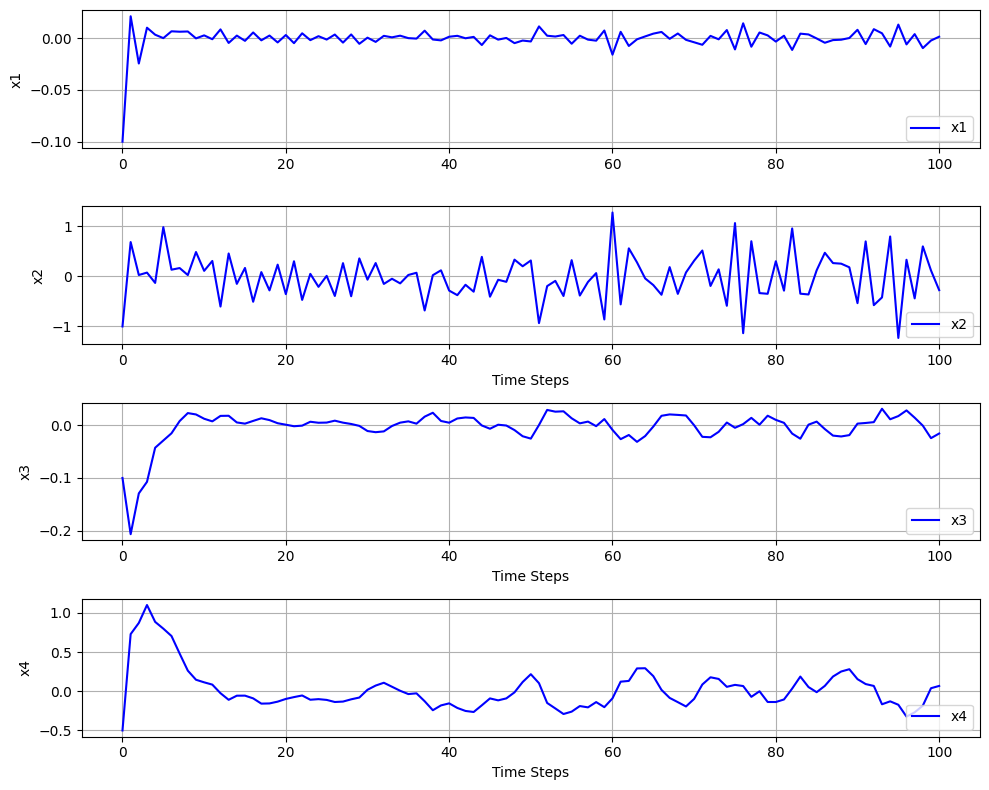

In [3]:
t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys[0,:], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys[1,:], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys[2,:], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys[3,:], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

try:

    # Run on single GPU

    DEVICE_ID = 0

    os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

    os.system("clear")

except:

    # Run on CPU

    os.system("clear")

    print("No GPU found.")

# Train the initial policy
Using the data based the method by Chen et al. (2018): sampling on the feasible state space, getting the LQR solution with the projection
Reference: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

df = pd.read_csv('Data_susp_CCD2.csv')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cuda device


In [7]:
lb_x = [-0.25,-2.5,-0.5,-2.5,env.ks_min,env.cs_min]; ub_x = [0.25,2.5,0.5,2.5,env.ks_max,env.cs_max]
model_initial = NeuralNetwork().to(device)
data = np.array(df)
input_data = data[:,0:6]
normalized_input_data = (input_data - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
output_data = data[:,6]/1000

In [8]:
# Convert data to PyTorch tensors
inputs = torch.tensor(normalized_input_data, dtype=torch.float32).to(device)
targets = torch.tensor(output_data, dtype=torch.float32).reshape(-1, 1)
targets = targets.to(device)

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.SGD(model_initial.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

num_epochs = 1000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        inputs_batch = inputs[i:i+batch_size]
        # Forward pass
        outputs = model_initial(inputs_batch)
        targets_batch = targets[i:i+batch_size]
        loss = criterion(outputs, targets_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.1086
Epoch [200/1000], Loss: 0.0580
Epoch [300/1000], Loss: 0.0116
Epoch [400/1000], Loss: 0.0076
Epoch [500/1000], Loss: 0.0079
Epoch [600/1000], Loss: 0.0082
Epoch [700/1000], Loss: 0.0084
Epoch [800/1000], Loss: 0.0084
Epoch [900/1000], Loss: 0.0085
Epoch [1000/1000], Loss: 0.0085


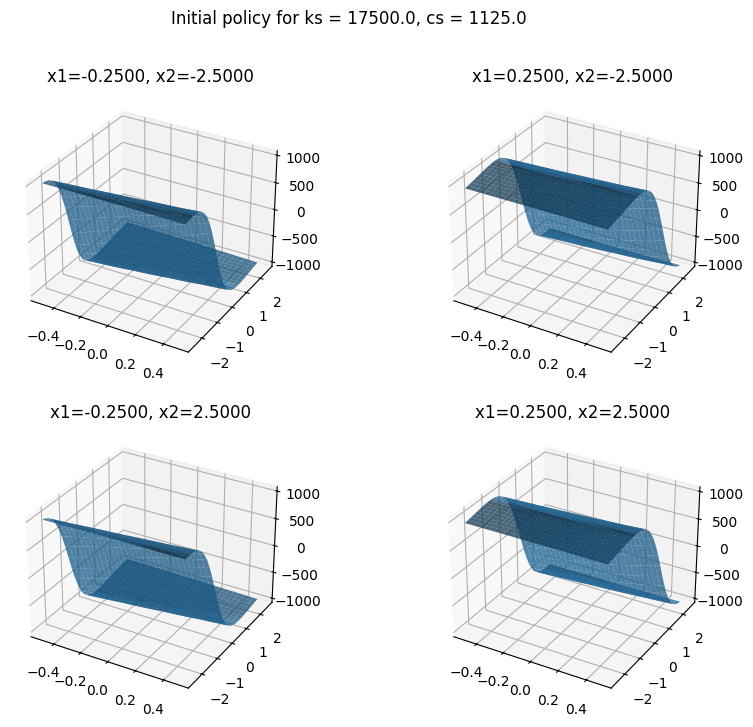

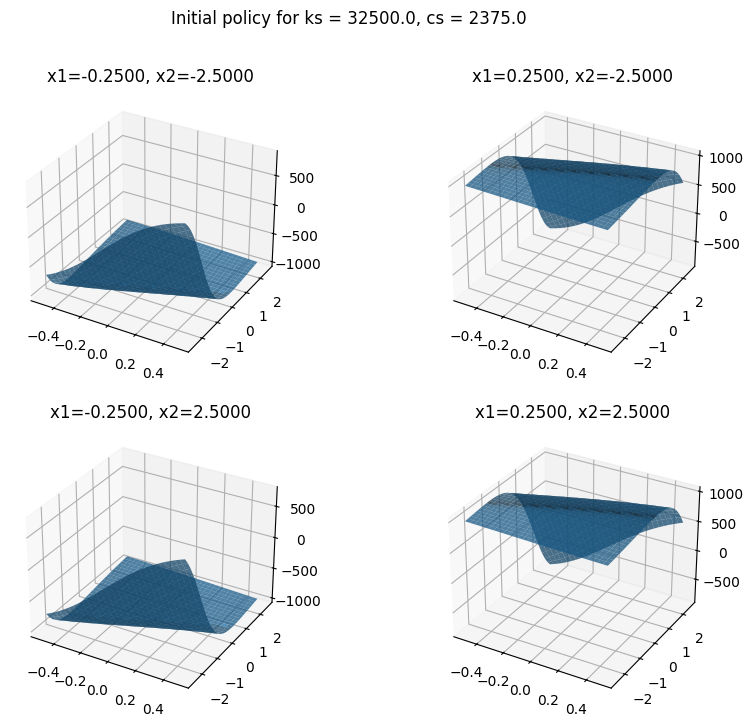

In [21]:
# Creating dataset
X1 = np.linspace(lb_x[0], ub_x[0], 2)
X2 = np.linspace(lb_x[1], ub_x[1], 2)
X3 = np.outer(np.linspace(lb_x[2], ub_x[2], 30), np.ones(30))
X4 = np.outer(np.linspace(lb_x[3], ub_x[3], 30), np.ones(30))
X4 = X4.T
ks_sample = np.linspace(lb_x[4], ub_x[4], 5)
cs_sample = np.linspace(lb_x[5], ub_x[5], 5)

Z = np.zeros((5,5,2,2,30,30))
for i1 in range(5):
    for i2 in range(5):
        for i in range(2):
            for j in range(2):
                for k in range(30):
                    for l in range(30):
                        inputs_tmp = np.array([X1[i],X2[j],X3[k,l],X4[k,l],ks_sample[i1],cs_sample[i2]])
                        inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
                        normalized_inputs_tmp = torch.tensor(inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
                        Z_tmp = model_initial(normalized_inputs_tmp)*1000
                        Z[i1,i2,i,j,k,l] = Z_tmp.item()

# Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
 
# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[1,1,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[1,1,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[1,1,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[1,1,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial policy for ks = '+str(ks_sample[1])+', cs = '+str(cs_sample[1]))
# Show plot
plt.show()

# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[3,3,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[3,3,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[3,3,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[3,3,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial policy for ks = '+str(ks_sample[3])+', cs = '+str(cs_sample[3]))
# Show plot
plt.show()


In [9]:
ks = 20000.0
ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs = 3000.0
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

s = env.reset(ks_normalized,cs_normalized)
print("Initial state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3]))
score = 0
x_sys = np.zeros((4,101))
x_sys[:,0] = s
a_sys = np.zeros((100,))

for i in range(100):
    # mu = model(torch.from_numpy(s).float())
    inputs_tmp = np.array([s[0],s[1],s[2],s[3],ks,cs])
    normalized_inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
    normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
    mu = model_initial(normalized_inputs_tmp)*1000
    dist = Normal(mu, torch.tensor(10).to(device)) # std = 10
    a = dist.sample()
    a = min(max(a.item(), env.action_space.low[0]), env.action_space.high[0])
    # a = min(max(a.item(), -500), 500)
    a_sys[i] = a
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    score += r
    print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime
print("Final score:{:.4f}".format(score))



Initial state:[-0.1000,-1.0000,-0.1000,-0.5000]
Current state:[-0.1000,-1.0000,-0.1000,-0.5000], Action: -547.2671, Reward: -8.9290, Next state:[0.0073,1.5180,-0.2101,0.9076]
Current state:[0.0073,1.5180,-0.2101,0.9076], Action: -634.1016, Reward: -5.4222, Next state:[0.0046,-0.7966,-0.1476,0.8118]
Current state:[0.0046,-0.7966,-0.1476,0.8118], Action: -584.8490, Reward: -2.9279, Next state:[0.0029,0.0116,-0.0997,0.6464]
Current state:[0.0029,0.0116,-0.0997,0.6464], Action: -512.5171, Reward: -2.9897, Next state:[-0.0040,0.5059,-0.0801,0.6558]
Current state:[-0.0040,0.5059,-0.0801,0.6558], Action: -555.1933, Reward: -2.3759, Next state:[0.0070,-0.0196,-0.0605,0.6138]
Current state:[0.0070,-0.0196,-0.0605,0.6138], Action: -457.8005, Reward: -0.9699, Next state:[0.0078,-0.2745,-0.0262,0.3605]
Current state:[0.0078,-0.2745,-0.0262,0.3605], Action: -265.0262, Reward: -0.2146, Next state:[0.0027,-0.0399,-0.0052,0.1681]
Current state:[0.0027,-0.0399,-0.0052,0.1681], Action: -164.7917, Reward

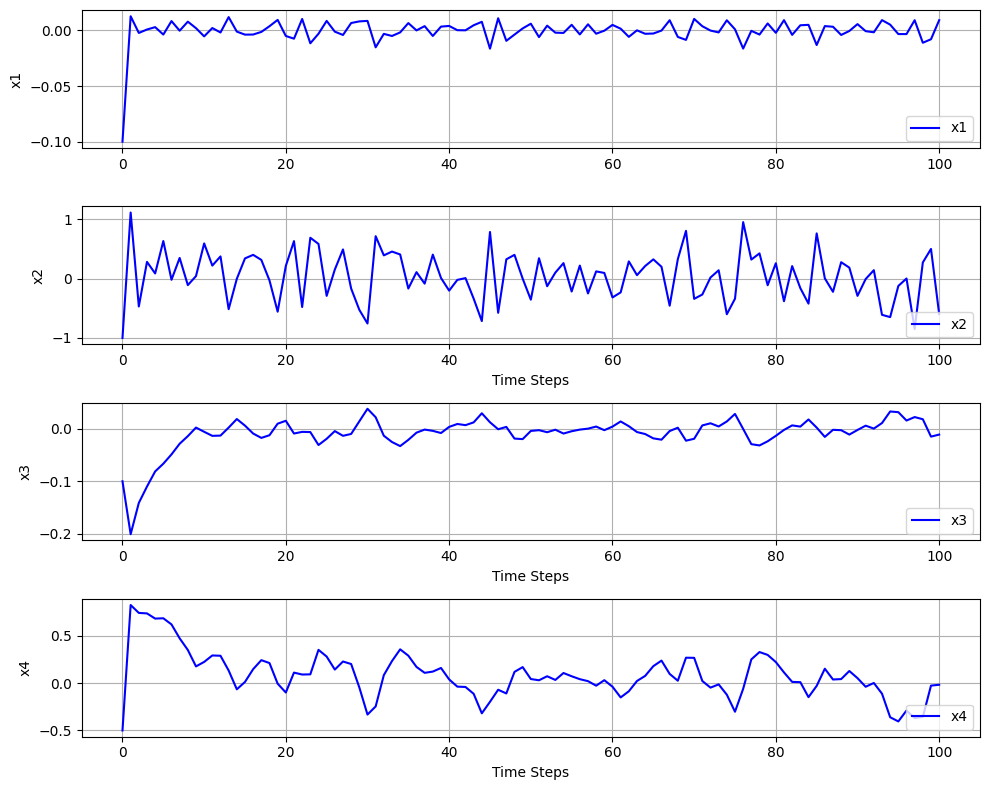

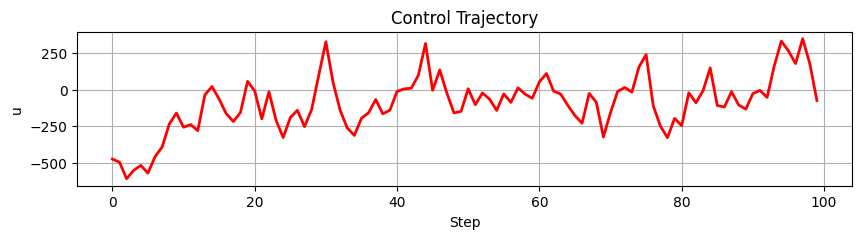

In [129]:
t_vec = np.arange(0, 101)

# Create the mean trajectories with 95% confidence interval
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(t_vec, x_sys[0,:], color='b', label='x1')
# ax1.set_xlabel('Time Steps')
ax1.set_ylabel('x1')
# ax1.set_ylim((-3.75,1.0))
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(t_vec, x_sys[1,:], color='b', label='x2')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('x2')
# ax2.set_ylim((-4,2))
ax2.legend(loc='lower right')
ax2.grid(True)


ax3.plot(t_vec, x_sys[2,:], color='b', label='x3')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('x3')
# ax3.set_ylim((-4,2))
ax3.legend(loc='lower right')
ax3.grid(True)

ax4.plot(t_vec, x_sys[3,:], color='b', label='x4')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('x4')
# ax4.set_ylim((-4,2))
ax4.legend(loc='lower right')
ax4.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(t_vec[:-1], a_sys, label='u', color='r', linestyle='-', linewidth=2)

plt.title('Control Trajectory')
plt.xlabel('Step')
plt.ylabel('u')

plt.grid(True)
plt.show()

# Train the initial value function

In [10]:
class NeuralNetworkValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [11]:
df = pd.read_csv('Data_value_susp_CCD2.csv')

model_initial_value = NeuralNetworkValue().to(device)
data_value = np.array(df)
output_data_value = data_value/1000

# Convert data to PyTorch tensors
targets_value = torch.tensor(output_data_value, dtype=torch.float32).reshape(-1, 1)
targets_value = targets_value.to(device)

optimizer_value = torch.optim.SGD(model_initial_value.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

num_epochs = 1000
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(input_data), batch_size):
        inputs_batch_value = inputs[i:i+batch_size]
        # Forward pass
        outputs_value = model_initial_value(inputs_batch_value)
        outputs_value = outputs_value.to(device)
        targets_batch_value = targets_value[i:i+batch_size]
        loss_value = criterion(outputs_value, targets_batch_value)

        # Backward pass and optimization
        optimizer_value.zero_grad()
        loss_value.backward()
        optimizer_value.step()
        
    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value.item():.4f}')



Epoch [100/1000], Loss: 0.1083
Epoch [200/1000], Loss: 0.0141
Epoch [300/1000], Loss: 0.0077
Epoch [400/1000], Loss: 0.0066
Epoch [500/1000], Loss: 0.0044
Epoch [600/1000], Loss: 0.0039
Epoch [700/1000], Loss: 0.0036
Epoch [800/1000], Loss: 0.0032
Epoch [900/1000], Loss: 0.0028
Epoch [1000/1000], Loss: 0.0026


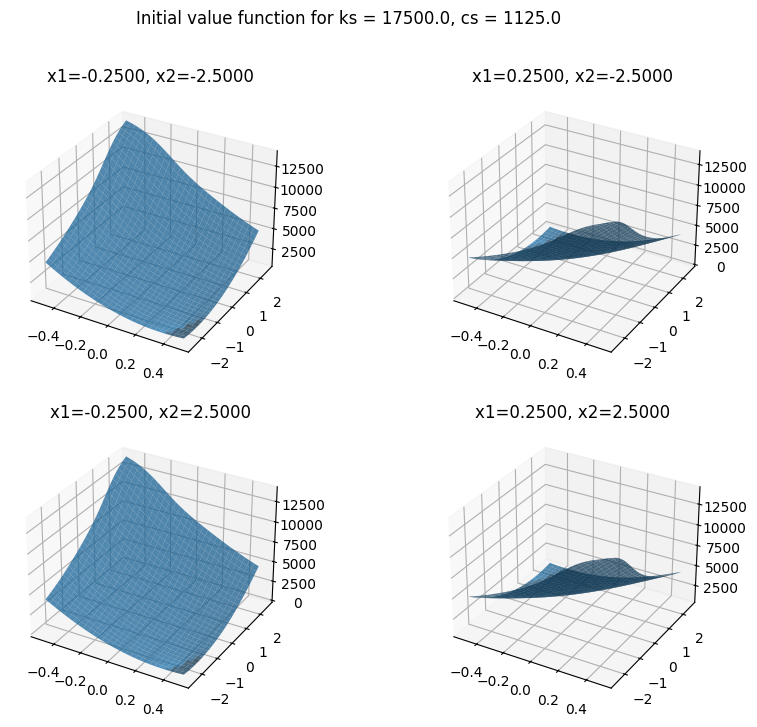

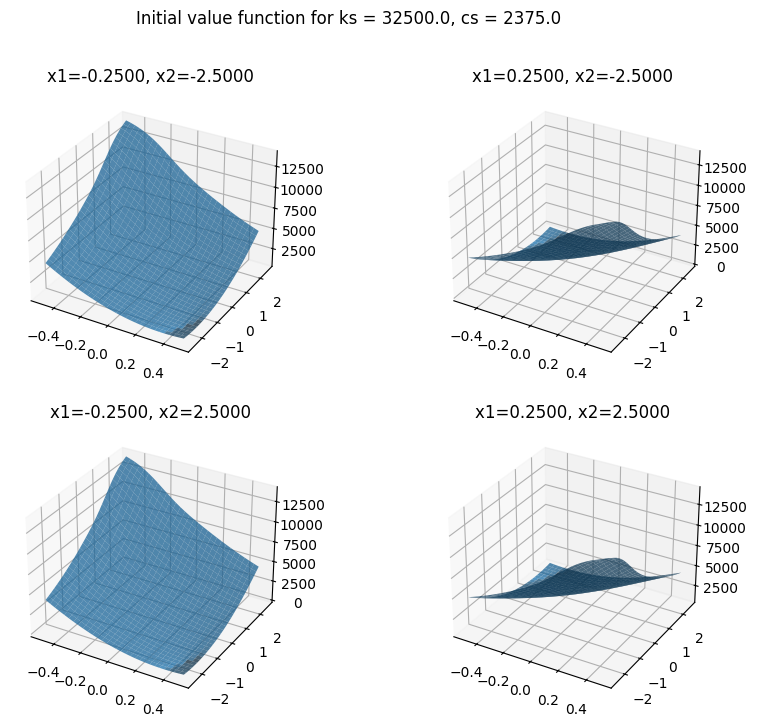

In [13]:
# Creating dataset
X1 = np.linspace(lb_x[0], ub_x[0], 2)
X2 = np.linspace(lb_x[1], ub_x[1], 2)
X3 = np.outer(np.linspace(lb_x[2], ub_x[2], 30), np.ones(30))
X4 = np.outer(np.linspace(lb_x[3], ub_x[3], 30), np.ones(30))
X4 = X4.T
ks_sample = np.linspace(lb_x[4], ub_x[4], 5)
cs_sample = np.linspace(lb_x[5], ub_x[5], 5)

Z = np.zeros((5,5,2,2,30,30))
for i1 in range(5):
    for i2 in range(5):
        for i in range(2):
            for j in range(2):
                for k in range(30):
                    for l in range(30):
                        inputs_tmp = np.array([X1[i],X2[j],X3[k,l],X4[k,l],ks_sample[i1],cs_sample[i2]])
                        inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
                        normalized_inputs_tmp = torch.tensor(inputs_tmp.reshape(1,6), dtype=torch.float32).to(device)
                        Z_tmp = model_initial_value(normalized_inputs_tmp)*1000
                        Z[i1,i2,i,j,k,l] = Z_tmp.item()

# Creating figure
# fig = plt.figure(figsize =(14, 9))
# ax = plt.axes(projection ='3d')
 
# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[1,1,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[1,1,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[1,1,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[1,1,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial value function for ks = '+str(ks_sample[1])+', cs = '+str(cs_sample[1]))
# Show plot
plt.show()

# Creating plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(X3, X4, Z[3,3,0,0,:,:], alpha=0.75)
ax1.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[0]))
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(X3, X4, Z[3,3,1,0,:,:], alpha=0.75)
ax2.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[0]))
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(X3, X4, Z[3,3,0,1,:,:], alpha=0.75)
ax3.title.set_text('x1='+'{0:.4f}'.format(X1[0])+', x2='+'{0:.4f}'.format(X2[1]))
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(X3, X4, Z[3,3,1,1,:,:], alpha=0.75)
ax4.title.set_text('x1='+'{0:.4f}'.format(X1[1])+', x2='+'{0:.4f}'.format(X2[1]))
plt.suptitle('Initial value function for ks = '+str(ks_sample[3])+', cs = '+str(cs_sample[3]))
# Show plot
plt.show()

Test if we can initialize the neural network model with the specified weights and bias

In [14]:
# Take out the weights and biases from a pretrained policy
model_parameter = list(model_initial.linear_relu_stack.parameters())
print(model_parameter[0].size()) # First layer weights
print(model_parameter[1].size()) # First layer biases
print(model_parameter[2].size()) # Second layer weights
print(model_parameter[3].size()) # Second layer biases
print(model_parameter[4].size()) # Third layer weights
print(model_parameter[5].size()) # Third layer biases
print(model_parameter[6].size()) # Forth layer weights
print(model_parameter[7].size()) # Forth layer biases
print(model_parameter[8].size()) # Output layer weights
print(model_parameter[9].size()) # Output layer biases

model_value_parameter = list(model_initial_value.linear_relu_stack.parameters())
print(model_value_parameter[0].size()) # First layer weights
print(model_value_parameter[1].size()) # First layer biases
print(model_value_parameter[2].size()) # Second layer weights
print(model_value_parameter[3].size()) # Second layer biases
print(model_value_parameter[4].size()) # Third layer weights
print(model_value_parameter[5].size()) # Third layer biases
print(model_value_parameter[6].size()) # Forth layer weights
print(model_value_parameter[7].size()) # Forth layer biases
print(model_value_parameter[8].size()) # Output layer weights
print(model_value_parameter[9].size()) # Output layer biases

xmin = np.min(input_data, axis=0, keepdims=True)
xmin = torch.tensor(xmin)
print(xmin[0,0:4])
xmax = np.max(input_data, axis=0, keepdims=True)
xmax = torch.tensor(xmax)


torch.Size([16, 6])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
torch.Size([16, 6])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
tensor([-0.2500, -2.4994, -0.4999, -2.4991], dtype=torch.float64)


## Hyparameters for RL-PPO

Suggestions from ChatGPT:
1. gamma: Discount Factor
2. lmbda: Generalized Advantage Estimation (GAE) Lambda. A lower lmbda reduces bias but increases variance, while a higher lmbda increases bias but smoothens advantage estimation. Try values in [0.8, 0.95].
3. eps_clip: Clipping Parameter. The eps_clip = 0.2 is typical for PPO, but you might experiment with slightly smaller values like 0.1 if the policy updates are too aggressive. A higher value make the policy update more aggresive
4. rollout_len: rollout length
5. buffer_size: buffer size (With rollout_len = 10 and buffer_size = 10, you’re processing relatively small batches. Increasing these values may improve gradient estimation at the expense of computational resources.)
6. minibatch_size: batch size. minibatch_size = 32 is a reasonable choice, but try increasing this (e.g., 64 or 128) to stabilize gradient updates.

Note: increasing buffer_size and minibatch_size increases the period of update and training but makes the gradient more stable.

In [15]:
#Hyperparameters
learning_rate       = 0.00001
learning_rate_plant = 0.00001
gamma               = 1
lmbda               = 0.9
eps_clip            = 0.2
K_epoch             = 20
rollout_len         = 20
buffer_size         = 10
minibatch_size      = 32

class PPO_num(nn.Module):
    def __init__(self):
        super(PPO_num, self).__init__()
        self.data = []

        self.fc1 = nn.Linear(6, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc_mu = nn.Linear(16, 1)

        self.fc5 = nn.Linear(6, 16)
        self.fc6 = nn.Linear(16, 32)
        self.fc7 = nn.Linear(32, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc_std  = nn.Linear(16, 1)

        self.fc9   = nn.Linear(6, 16)
        self.fc10  = nn.Linear(16, 32)
        self.fc11  = nn.Linear(32, 32)
        self.fc12  = nn.Linear(32, 16)
        self.fc_v  = nn.Linear(16, 1)

        with torch.no_grad():
            # Weights and bias for policy function (mean)
            self.fc1.weight.copy_(model_parameter[0])
            self.fc1.bias.copy_(model_parameter[1])
            self.fc2.weight.copy_(model_parameter[2])
            self.fc2.bias.copy_(model_parameter[3])
            self.fc3.weight.copy_(model_parameter[4])
            self.fc3.bias.copy_(model_parameter[5])
            self.fc4.weight.copy_(model_parameter[6])
            self.fc4.bias.copy_(model_parameter[7])
            self.fc_mu.weight.copy_(model_parameter[8])
            self.fc_mu.bias.copy_(model_parameter[9])

            # Weights and bias for policy function (std)
            self.fc5.weight.copy_(torch.zeros(16, 6))
            self.fc5.bias.copy_(torch.ones(16,)*0.01)
            self.fc6.weight.copy_(torch.zeros(32, 16))
            self.fc6.bias.copy_(torch.ones(32,)*0.01)
            self.fc7.weight.copy_(torch.zeros(32, 32))
            self.fc7.bias.copy_(torch.ones(32,)*0.01)
            self.fc8.weight.copy_(torch.zeros(16,32))
            self.fc8.bias.copy_(torch.ones(16,)*0.01)
            self.fc_std.weight.copy_(torch.zeros(16,))
            self.fc_std.bias.copy_(torch.ones(1,)*0.1)

            # Weights and bias for value function
            self.fc9.weight.copy_(model_value_parameter[0])
            self.fc9.bias.copy_(model_value_parameter[1])
            self.fc10.weight.copy_(model_value_parameter[2])
            self.fc10.bias.copy_(model_value_parameter[3])
            self.fc11.weight.copy_(model_value_parameter[4])
            self.fc11.bias.copy_(model_value_parameter[5])
            self.fc12.weight.copy_(model_value_parameter[6])
            self.fc12.bias.copy_(model_value_parameter[7])
            self.fc_v.weight.copy_(model_value_parameter[8])
            self.fc_v.bias.copy_(model_value_parameter[9])

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-4)
        self.optimization_step = 0

    def pi(self, x, max_value = 0.5):
        Tanh_fuc = nn.Tanh()
        Softplus_fuc= nn.Softplus(beta=100) # To avoid negative value for std
        f1 = self.fc1(x)
        f2 = self.fc2(Tanh_fuc(f1))
        f3 = self.fc3(f2)
        f4 = self.fc4(Tanh_fuc(f3))
        mu = self.fc_mu(f4)
        
        f5 = self.fc5(x)
        f6 = self.fc6(Tanh_fuc(f5))
        f7 = self.fc7(f6)
        f8 = self.fc8(Tanh_fuc(f7))
        # std = F.softplus(self.fc_std(f6))
        std = torch.min(Softplus_fuc(self.fc_std(f8)), torch.tensor(max_value))
        return mu, std
    
    def v(self, x):
        # x = F.relu(self.fc1(x))
        # v = self.fc_v(x)
        Tanh_fuc = nn.Tanh()
        f9 = self.fc9(x)
        f10 = self.fc10(Tanh_fuc(f9))
        f11 = self.fc11(f10)
        f12 = self.fc12(Tanh_fuc(f11))
        v = self.fc_v(f12)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data, ks = 27692.0, cs = 1906.5):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                tensor_size = torch.Tensor.size(s_prime)
                new_tensor1 = torch.full((tensor_size[0],tensor_size[1],1), ks)
                new_tensor2 = torch.full((tensor_size[0],tensor_size[1],1), cs)
                # Concatenate the original tensor and the new tensor along the last dimension
                x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                x_normalized = (x-xmin)/(xmax-xmin)
                x_normalized = x_normalized.type(torch.float32)
                x_prime = torch.cat((s_prime, new_tensor1, new_tensor2), dim=2)
                x_prime_normalized = (x_prime-xmin)/(xmax-xmin)
                x_prime_normalized = x_prime_normalized.type(torch.float32)
                td_target = r + gamma * self.v(x_prime_normalized)
                delta = td_target - self.v(x_normalized)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

    def train_net_CCD(self,ks,cs): # co-optimizing policy and the system parameter p
        global p_torch
        ks_torch = torch.tensor(ks, dtype=torch.float32)
        cs_torch = torch.tensor(cs, dtype=torch.float32)
        tensor_list = [(ks_torch-xmin[0,4])/(xmax[0,4]-xmin[0,4]),(cs_torch-xmin[0,5])/(xmax[0,5]-xmin[0,5])]
        p_torch = torch.tensor([t.item() for t in tensor_list], dtype=torch.float64, requires_grad=True) # Convert the list of tensors into a single tensor
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            data = self.calc_advantage(data,ks,cs)
            # optimizer_p = torch.optim.SGD([p_torch], lr=0.001) # define the optimizer that only updates p
            optimizer_p = torch.optim.Adam([p_torch], lr=learning_rate_plant, weight_decay=1e-4) # define the optimizer that only updates p; 'weight_decay' can help with overfitting

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    # compute the loss and gradient
                    tensor_size = torch.Tensor.size(s)
                    new_tensor1 = p_torch[0].expand(tensor_size[0], tensor_size[1], 1)
                    new_tensor2 = p_torch[1].expand(tensor_size[0], tensor_size[1], 1)
                    # Concatenate the original tensor and the new tensor along the last dimension
                    x_normalized = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x = torch.cat((s, new_tensor1, new_tensor2), dim=2)
                    # x_normalized = (x-xmin)/(xmax-xmin)
                    x_normalized = x_normalized.type(torch.float32)
                    mu, std = self.pi(x_normalized, max_value=0.5)
                    dist = Normal(mu, std)
                    log_prob = dist.log_prob(a)
                    ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                    surr1 = ratio * advantage
                    surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                    # clamp function ensures ratio is within the range
                    loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(x_normalized) , td_target)
                    # compute the Smooth L1 loss, which is less sensitive to outliers than the MSE loss

                    # autograd
                    optimizer_p.zero_grad()
                    loss.mean().backward(retain_graph=True) # Perform backward pass to compute gradients
                    optimizer_p.step()
                    # print(p_torch)

                    self.optimizer.zero_grad()
                    loss.mean().backward() # compute the gradients of the loss with respect to the model parameters
                    nn.utils.clip_grad_norm_(self.parameters(), 1.0) # clip the gradients' norm to prevent the exploding gradient problem, clipped to a maximum of 1.0 in this case
                    self.optimizer.step() # update the model parameters using the gradients computed during backpropagation
                    self.optimization_step += 1
        return p_torch[0], p_torch[1]


## Define system env and PPO and Initialize physical parameters (ks: spring constant and cs: damping ratio)

In [ ]:
env = DynamicSystemEnv()
RLmodel_initial = PPO_num()
ks = 27692.0
cs = 1906.5

## Co-Design

In [17]:
import copy

model = copy.deepcopy(RLmodel_initial)

xmin_array = xmin.numpy()
xmax_array = xmax.numpy()

ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)
print_interval = 10
rollout = []
score_total = 0.0
score_history = []
ks_history = []
cs_history = []
patience = 100
threshold = 0.01  # Minimum improvement considered significant
best_reward = -float('inf')  # Initialize best reward
no_improvement_count = 0  # Counter for no improvement
for n_epi in range(10000):
    s = env.reset(ks_normalized,cs_normalized)
    done = False
    count = 0
    score = 0.0
    while count < 100:
        for t in range(rollout_len):
            x_tmp = np.append(s,ks)
            x_tmp = np.append(x_tmp,cs)
            s_normalized = (s - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            x = (x_tmp - xmin_array[0]) / (xmax_array[0] - xmin_array[0])
            normalized_inputs_tmp = torch.tensor(x.reshape(1,6), dtype=torch.float32)
            mu, std = model.pi(normalized_inputs_tmp)
            dist = Normal(mu, std)
            a = dist.sample()
            log_prob = dist.log_prob(a)
            action = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
            s_prime, r, done, _ = env.step([action],ks_normalized,cs_normalized)
            s_prime_normalized = (s_prime - xmin_array[0][0:4]) / (xmax_array[0][0:4] - xmin_array[0][0:4])
            rollout.append((s_normalized, action/1000, r/1000.0, s_prime_normalized, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []

            s = s_prime

            score += r
            count += 1

        ks_torch_new, cs_torch_new = model.train_net_CCD(ks,cs)
        ks_normalized_ccd = ks_torch_new.item()
        cs_normalized_ccd = cs_torch_new.item()
        
        # Note that the normalizations for CCD training and step(), reset() are different
        ks = ks_normalized_ccd*(xmax[0,4]-xmin[0,4]) + xmin[0,4]
        cs = cs_normalized_ccd*(xmax[0,5]-xmin[0,5]) + xmin[0,5]
        
        ks_normalized = (ks-env.ks_min)/(env.ks_max-env.ks_min)
        cs_normalized = (cs-env.cs_min)/(env.cs_max-env.cs_min)

    score_total = score_total+score
    score_history.append([n_epi,score])
    ks_history.append([n_epi,ks])
    cs_history.append([n_epi,cs])

    # print("# of episode :{}, score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, score, ks, cs))

    if n_epi%print_interval==0 and n_epi!=0:
        if n_epi==10:
            avg_score = score_total/(print_interval+1)
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        else:
            avg_score = score_total/print_interval
            print("# of episode :{}, avg score : {:.1f}, ks = {:.4f}, cs = {:.4f}".format(n_epi, avg_score, ks, cs))
        score_total = 0.0

        # Check if we have improved
        if avg_score > best_reward + 0.01:
            best_reward = avg_score
            no_improvement_count = 0  # Reset the counter
        else:
            no_improvement_count += 1

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"Early stopping triggered at epoch {n_epi} with reward {avg_score}")
            break

env.close()
print("The final ks = {:.4f}".format(ks)+', cs = {:.4f}'.format(cs))

/tmp/ipykernel_2690400/3586463910.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ks_torch = torch.tensor(ks, dtype=torch.float32)
/tmp/ipykernel_2690400/3586463910.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cs_torch = torch.tensor(cs, dtype=torch.float32)


# of episode :10, avg score : -59.3, ks = 20000.0000, cs = 3000.0000
# of episode :20, avg score : -61.9, ks = 20000.0000, cs = 3000.0000
# of episode :30, avg score : -63.4, ks = 20000.0000, cs = 3000.0000
# of episode :40, avg score : -69.5, ks = 20000.0000, cs = 3000.0000
# of episode :50, avg score : -62.1, ks = 20000.0000, cs = 3000.0000
# of episode :60, avg score : -62.1, ks = 20000.0000, cs = 3000.0000


/tmp/ipykernel_2690400/3586463910.py:133: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \


KeyboardInterrupt: 

In [149]:
import matplotlib.pyplot as plt

score_history_array = np.array(score_history).T
epoch = score_history_array[0,:]
score_history_array = score_history_array[1,:]
score_history_avg = score_history_array.reshape(-1, 10).mean(axis=1)

ks_history_array = np.array(ks_history).T
ks_history_array = ks_history_array[1,:]
cs_history_array = np.array(cs_history).T
cs_history_array = cs_history_array[1,:]

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], score_history_avg)
plt.xlabel('Epoch')
plt.ylabel('Average Return')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], ks_history_array[::10])
plt.xlabel('Epoch')
plt.ylabel('$k_s$ (Spring constant)')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epoch[::10], cs_history_array[::10])
plt.xlabel('Epoch')
plt.ylabel('$c_s$ (Damping constant)')
plt.show()

ValueError: cannot reshape array of size 1221 into shape (10)

In [113]:
s = env.reset(ks_normalized,cs_normalized)
print("Initial state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3]))
score = 0
x_sys = np.zeros((4,101))
x_sys[:,0] = s
a_sys = np.zeros((100,))

for i in range(100):
    # mu = model(torch.from_numpy(s).float())
    inputs_tmp = np.array([s[0],s[1],s[2],s[3],ks,cs])
    normalized_inputs_tmp = (inputs_tmp - np.min(input_data, axis=0, keepdims=True)) / (np.max(input_data, axis=0, keepdims=True) - np.min(input_data, axis=0, keepdims=True))
    normalized_inputs_tmp = torch.tensor(normalized_inputs_tmp.reshape(1,6), dtype=torch.float32)
    mu, std = model.pi(normalized_inputs_tmp)
    dist = Normal(mu, std)
    a = dist.sample()
    a = min(max(a.item()*1000, env.action_space.low[0]), env.action_space.high[0])
    # a = min(max(a.item(), -500), 500)
    a_sys[i] = a
    s_prime, r, done, _ = env.step(a,ks_normalized,cs_normalized)
    x_sys[:,i+1] = s_prime
    score += r
    print("Current state:[{:.4f},{:.4f},{:.4f},{:.4f}], Action: {:.4f}, Reward: {:.4f}, Next state:[{:.4f},{:.4f},{:.4f},{:.4f}]".format(s[0],s[1],s[2],s[3],a,r,s_prime[0],s_prime[1],s_prime[2],s_prime[3]))
    s = s_prime
print("Final score:{:.4f}".format(score))



Initial state:[-0.1000,-1.0000,-0.1000,-0.5000]
Current state:[-0.1000,-1.0000,-0.1000,-0.5000], Action: -782.1648, Reward: -11.4469, Next state:[0.0045,1.8187,-0.2288,0.9910]
Current state:[0.0045,1.8187,-0.2288,0.9910], Action: -1000.0000, Reward: -10.3148, Next state:[-0.0083,-1.1687,-0.1337,1.1878]
Current state:[-0.0083,-1.1687,-0.1337,1.1878], Action: -1000.0000, Reward: -8.5427, Next state:[0.0053,0.5085,-0.0802,1.1800]
Current state:[0.0053,0.5085,-0.0802,1.1800], Action: -1000.0000, Reward: -5.4482, Next state:[0.0101,-0.2740,-0.0235,0.9322]
Current state:[0.0101,-0.2740,-0.0235,0.9322], Action: -897.9399, Reward: -2.6203, Next state:[0.0085,0.2942,0.0107,0.5867]
Current state:[0.0085,0.2942,0.0107,0.5867], Action: -637.7191, Reward: -0.8343, Next state:[0.0125,-0.3206,0.0351,0.2288]
Current state:[0.0125,-0.3206,0.0351,0.2288], Action: -164.8863, Reward: -0.7606, Next state:[-0.0040,0.8226,0.0287,0.0554]
Current state:[-0.0040,0.8226,0.0287,0.0554], Action: -223.5116, Reward:

## Save the trained model

In [ ]:
import pickle

variables_to_save = {
    'model_initial': model_initial, # RL model
    'model': model, # RL model after a generation (updated policy and value) and will be used for update
    'model_retrain': model_retrain, # RL model
    'ks': ks, # system parameter
    'cs': cs, # system parameter
    'env': env,
    'ks_history_array': ks_history_array,
    'cs_history_array': cs_history_array,
    'score_history_avg': score_history_avg,
    # Add more variables as needed
}


with open('RL_PPO_susp_CCD_first_optimization_data.pkl', 'wb') as file:
    pickle.dump(variables_to_save, file)
